In [1]:
import numpy as np

pi = np.pi

# loop through all torsions for C -- C bond
delta_ij = np.array([0, 2*pi/3, 4*pi/3, 4*pi/3, 0, 2*pi/3, 2*pi/3, 4*pi/3, 0])

#c_hidx,hidx
c_25 = 4
c_26 = 2
c_27 = 2
c_35 = 2
c_36 = 1
c_37 = 1
c_45 = 2
c_46 = 1
c_47 = 1

#c_25 = 2
#c_26 = 4
#c_27 = 2
#c_35 = 1
#c_36 = 2
#c_37 = 1
#c_45 = 1
#c_46 = 2
#c_47 = 1

c_ij = np.array([c_25, c_26, c_27, c_35, c_36, c_37, c_45, c_46, c_47])

def calc_s(delta_ij, c_ij):
    '''given ∆_(ij) returns a vector [cos(∆_(ij)), sin(∆_(ij))], s'''
    # turn into a 9X2 array
    s_ij = np.vstack((np.cos(delta_ij), np.sin(delta_ij))).T 
    
    cs_ij = c_ij[:, np.newaxis] * s_ij
    #print(f'c*s = {s_ij}')
    s = np.sum(cs_ij, axis=0)
    return s

def calc_alpha(s):
    '''given s returns a torsion angle, alpha'''
    r = np.sqrt(s[0]**2 + s[1]**2)
    #alpha = np.arctan2(r*np.cos(s[0]/r), r*np.sin(s[1]/r)) # probably wrong
    alpha = np.arctan2(s[0] / r, s[1] / r)
    
    return alpha

# rotate by some amount
gamma = 0.1

rotated_delta_ij = delta_ij + gamma
#print(f'original torsions: {delta_ij}, \nrotated torsions: {rotated_delta_ij}')

s = calc_s(delta_ij, c_ij)
#print(s)
s_rotated = calc_s(rotated_delta_ij, c_ij)
print(f'original s: {s}, \nrotated s: {s_rotated}')

a = calc_alpha(s)
a_rotated = calc_alpha(s_rotated)
#print(f'original a: {a}, \nrotated a: {a_rotated}')
#print((a_rotated - a)/pi)

print(a, a_rotated)

original s: [1.00000000e+00 1.55431223e-15], 
rotated s: [0.99500417 0.09983342]
1.570796326794895 1.4707963267948945


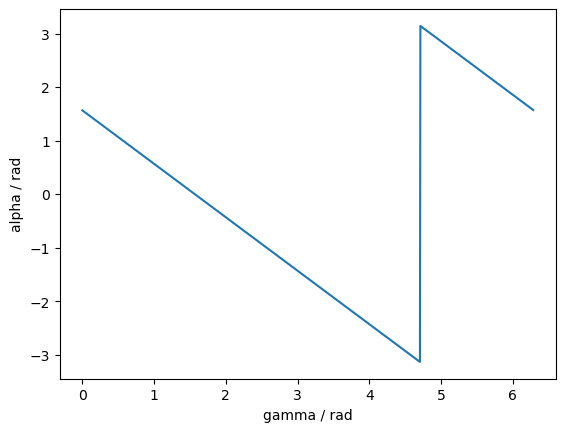

In [2]:
import pylab

rotated_delta_ij = delta_ij
a_list = []

for i in range(1000):
    gamma = 2*pi/1000

    for j in range(9):
        if rotated_delta_ij[j] + gamma < 2*pi:
            rotated_delta_ij[j] = rotated_delta_ij[j] + gamma
        else:
            rotated_delta_ij[j] = rotated_delta_ij[j] + gamma - 2*pi
        
    s_rotated = calc_s(rotated_delta_ij, c_ij)
    a_rotated = calc_alpha(s_rotated)
    a_list.append(a_rotated)

x_list = np.linspace(0, 2*pi, 1000)
pylab.plot(x_list, a_list)
pylab.ylabel("alpha / rad")
pylab.xlabel("gamma / rad")
pylab.savefig("out.png")

In [3]:


# # folder = pathlib.Path("TNet500_minimal")
# # outputfile = h5py.File('TNet500-SPICE.hdf5', 'w')

# file = 'biaryl_minimal/result_biaryl_016.json'
# td_result = TorsionDriveResult.parse_file(file)
# folder = pathlib.Path("biaryl_minimal")
# energies, gradients, conformations = [], [], []
# for angle, molecule in td_result.final_molecules.items():
#     energies.append(td_result.final_energies[angle])
#     conformations.append(molecule.geometry)
#     gradients.append(td_result.optimization_history[angle][0].trajectory[0].properties.return_gradient)
# if "conformations" in group:
#     del group["conformations"]  # delete existing dataset if it exists
# conformations = group.create_dataset("conformations", data=np.array(conformations), dtype=np.float32)
# conformations.attrs["units"] = "bohr"
# if "dft total energy" in group:
#     del group["dft total energy"]
# ds = group.create_dataset("dft total energy", data=np.array(energies), dtype=np.float64)
# ds.attrs["units"] = "hartree"
# if "dft total gradient" in group:
#     del group["dft total gradient"]
# ds = group.create_dataset('dft total gradient', data=np.array(gradients), dtype=np.float32)
# ds.attrs["units"] = "hartree/bohr"

# td_result.keywords.dihedrals[0]

# # 17 atoms
# # 24 confs
# # 3 coords
# import rdkit
# from rdkit import Chem
# from rdkit.Chem import AllChem

# mol_16_90 = td_result.final_molecules['-90']
# mol_16_165 = td_result.final_molecules['-165']

In [4]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Geometry import Point3D
import numpy as np
import qcelemental
import h5py
from qcelemental.models.procedures import TorsionDriveResult
import numpy as np
import pathlib

outputfile = h5py.File('xBiaryl-SPICE.hdf5', 'w')

def parse_qcjson(filename):
    td_result = TorsionDriveResult.parse_file(filename)
    smiles = td_result.initial_molecule[0].extras["canonical_isomeric_explicit_hydrogen_mapped_smiles"]
    name = smiles.replace("/", "")
    # unused as of yet
    group = outputfile.create_group(name)
    group.create_dataset("smiles", data=[smiles], dtype=h5py.string_dtype())
    group.create_dataset("atomic_numbers", data=td_result.initial_molecule[0].atomic_numbers, dtype=np.int16)
    energies, gradients, conformations = [], [], []
    for angle, molecule in td_result.final_molecules.items():
        energies.append(td_result.final_energies[angle])
        conformations.append(molecule.geometry)
        gradients.append(td_result.optimization_history[angle][0].trajectory[0].properties.return_gradient)
    if "conformations" in group:
        del group["conformations"]  # delete existing dataset if it exists
    conformations = group.create_dataset("conformations", data=np.array(conformations), dtype=np.float32)
    conformations.attrs["units"] = "bohr"
    if "dft total energy" in group:
        del group["dft total energy"]
    ds = group.create_dataset("dft total energy", data=np.array(energies), dtype=np.float64)
    ds.attrs["units"] = "hartree"
    if "dft total gradient" in group:
        del group["dft total gradient"]
    ds = group.create_dataset('dft total gradient', data=np.array(gradients), dtype=np.float32)
    ds.attrs["units"] = "hartree/bohr"
    
    return td_result

filename = 'biaryl_minimal/result_biaryl_016.json'
td_result = parse_qcjson(filename)
td_result.final_energies

{'-165': -816.505816559494,
 '-150': -816.5039187209546,
 '-135': -816.5011012287301,
 '-120': -816.4979629209311,
 '-105': -816.4954187225007,
 '-90': -816.494428046986,
 '-75': -816.4954301422798,
 '-60': -816.4979679186425,
 '-45': -816.5010865037865,
 '-30': -816.5038982293839,
 '-15': -816.5058087109574,
 '0': -816.506481242779,
 '15': -816.505808917845,
 '30': -816.5038983176088,
 '45': -816.5010866947375,
 '60': -816.4979678635927,
 '75': -816.4954297335078,
 '90': -816.4944281315253,
 '105': -816.495418981877,
 '120': -816.4979625597838,
 '135': -816.5011010654134,
 '150': -816.5039187926249,
 '165': -816.5058167183216,
 '180': -816.5064807405599}

In [5]:
def qcmol_to_rdkit(qcmol):
#     # qcelemental mol data
#     symbols = qcmol.symbols
#     geometry = qcmol.geometry
#     connectivity = qcmol.connectivity
    
#     # empty RDKit molecule
#     mol = Chem.RWMol()
    
#     # add atoms to the molecule
#     atom_indices = []
#     for symbol in symbols:
#         atom = Chem.Atom(symbol)
#         idx = mol.AddAtom(atom)
#         atom_indices.append(idx)
#         #print(atom, idx, atom_indices)
#     # add bonds to the molecule
#     for i, j, order in connectivity:
#         bond_order = Chem.BondType.SINGLE if order == 1.0 else Chem.BondType.DOUBLE if order == 2.0 else Chem.BondType.TRIPLE
#         mol.AddBond(atom_indices[i], atom_indices[j], bond_order)
    
#     # convert to an editable Mol object
#     mole = mol.GetMol()
    
#     # generate an initial conformer and set the coordinates
#     conf = Chem.Conformer(mol.GetNumAtoms())
#     for i, (x, y, z) in enumerate(geometry):
#         conf.SetAtomPosition(i, Point3D(x, y, z))
#     mol.AddConformer(conf)
    mol = Molecule.from_qcschema(qcmol)
    rdkit_mol = mol.to_rdkit()
    return rdkit_mol

def gen_mol_dict(td_result):
    mol_dict = {}
    dihedral_idxs = td_result.keywords.dihedrals[0]
    for angle, qcmol in td_result.final_molecules.items():
        energy = td_result.final_energies[angle]
        mol = qcmol_to_rdkit(qcmol)
        for i,idx in enumerate(dihedral_idxs):
            mol.SetProp(f'dihedral_{i}', str(idx))
        mol.SetProp('energy', str(energy))
        mol_dict[(float(angle)/360) / (2*np.pi)] = Chem.Mol(mol)
    return mol_dict
    
mol_dict = gen_mol_dict(td_result)
for mol in mol_dict.values():
    print(mol.GetProp('energy'))
mol_dict

-816.505816559494
-816.5039187209546
-816.5011012287301
-816.4979629209311
-816.4954187225007
-816.494428046986
-816.4954301422798
-816.4979679186425
-816.5010865037865
-816.5038982293839
-816.5058087109574
-816.506481242779
-816.505808917845
-816.5038983176088
-816.5010866947375
-816.4979678635927
-816.4954297335078
-816.4944281315253
-816.495418981877
-816.4979625597838
-816.5011010654134
-816.5039187926249
-816.5058167183216
-816.5064807405599


{-0.07294601558378536: <rdkit.Chem.rdchem.Mol at 0x741784aaa570>,
 -0.06631455962162307: <rdkit.Chem.rdchem.Mol at 0x741784aaa1b0>,
 -0.05968310365946075: <rdkit.Chem.rdchem.Mol at 0x741784aaa160>,
 -0.05305164769729844: <rdkit.Chem.rdchem.Mol at 0x741784aa92b0>,
 -0.046420191735136146: <rdkit.Chem.rdchem.Mol at 0x741784a3b330>,
 -0.039788735772973836: <rdkit.Chem.rdchem.Mol at 0x741784a3b2e0>,
 -0.033157279810811534: <rdkit.Chem.rdchem.Mol at 0x741784a3b290>,
 -0.02652582384864922: <rdkit.Chem.rdchem.Mol at 0x741784a3b240>,
 -0.019894367886486918: <rdkit.Chem.rdchem.Mol at 0x741784a3b1f0>,
 -0.01326291192432461: <rdkit.Chem.rdchem.Mol at 0x741784a3b060>,
 -0.006631455962162305: <rdkit.Chem.rdchem.Mol at 0x741784a3b100>,
 0.0: <rdkit.Chem.rdchem.Mol at 0x741784a3b0b0>,
 0.006631455962162305: <rdkit.Chem.rdchem.Mol at 0x741784a3b010>,
 0.01326291192432461: <rdkit.Chem.rdchem.Mol at 0x741784a3afc0>,
 0.019894367886486918: <rdkit.Chem.rdchem.Mol at 0x741784a3af70>,
 0.02652582384864922: <

In [6]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolTransforms
import numpy as np

# random mol
mol = mol_dict[0.0]

Bond between Atom 0 (N) and Atom 4 (C)
Bond between Atom 0 (N) and Atom 1 (C)
Bond between Atom 1 (C) and Atom 5 (N)
Bond between Atom 1 (C) and Atom 2 (C)
Bond between Atom 2 (C) and Atom 3 (S)
Bond between Atom 2 (C) and Atom 6 (C)
Bond between Atom 3 (S) and Atom 7 (C)
Bond between Atom 4 (C) and Atom 8 (C)
Bond between Atom 4 (C) and Atom 13 (H)
Bond between Atom 5 (N) and Atom 9 (C)
Bond between Atom 6 (C) and Atom 10 (C)
Bond between Atom 6 (C) and Atom 11 (H)
Bond between Atom 7 (C) and Atom 10 (C)
Bond between Atom 7 (C) and Atom 14 (H)
Bond between Atom 8 (C) and Atom 9 (C)
Bond between Atom 8 (C) and Atom 15 (H)
Bond between Atom 9 (C) and Atom 16 (H)
Bond between Atom 10 (C) and Atom 12 (H)


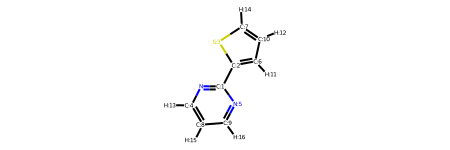

In [7]:
# get the conformer 
conformer = mol.GetConformer(0)

# Iterate over all bonds in the molecule
for bond in mol.GetBonds():
    # Get the atoms associated with the bond
    atom1 = bond.GetBeginAtom() 
    atom2 = bond.GetEndAtom()   
    
    
    print(f"Bond between Atom {atom1.GetIdx()} ({atom1.GetSymbol()}) "
          f"and Atom {atom2.GetIdx()} ({atom2.GetSymbol()})")
def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol

# identifies atoms /w dihedral
mol_with_atom_index(mol)

In [8]:
def get_dihedrals(mol, return_features=True):
        # get list of sets of atom indexes
        # every atom connected to begin atom
        # with every atom connected to end atom
        # [X, begin, end, Y] e.g. ethane has 3*3, so list of lists, len 9
        
        begin_atom = int(mol.GetProp('dihedral_1'))
        end_atom = int(mol.GetProp('dihedral_2'))
        conformer=mol.GetConformer(0)
        #print(f'begin atom: {begin_atom}; end atom: {end_atom}')
    
        # get neighbours of the begin atom
        begin_neighbours = mol.GetAtomWithIdx(begin_atom).GetNeighbors()
        begin_nbr_idxs = [neighbour.GetIdx() for neighbour in begin_neighbours]
        #print("Begin atom neighbors:", begin_nbr_idxs)
        
        # and for end
        end_neighbours = mol.GetAtomWithIdx(end_atom).GetNeighbors()
        end_nbr_idxs = [neighbour.GetIdx() for neighbour in end_neighbours]
        #print("End atom neighbors:", end_nbr_idxs)
        
        # get indices for dihedrals by looping through bond atom neighbours
        # first remove neighbour that is in the bond
        begin_nbr_idxs.remove(end_atom)
        end_nbr_idxs.remove(begin_atom)
    
        dihedral_indices = []
        for nbr_b in begin_nbr_idxs:
            for nbr_e in end_nbr_idxs:
                dihedral = [nbr_b] + [begin_atom, end_atom] + [nbr_e]
                dihedral_indices.append(dihedral)
        dihedral_atoms = [mol.GetAtomWithIdx(idx[0]) for idx in dihedral_indices]

        if return_features:
            # generating features as dummy atomic number
            c = [atm.GetAtomicNum() for atm in dihedral_atoms]

        # calc dihedral angle for each
        dihedral_angles = []
        conf = mol.GetConformer(0)
        for indices in dihedral_indices:
            #print(indices)
            dihedral = rdMolTransforms.GetDihedralRad(conf, *indices)
            dihedral_angles.append(dihedral)
            #print(dihedral)
        #print(dihedral_indices)
        #print(dihedral_angles)
        return np.array(dihedral_angles), np.array(c)

#def compute_features
dihedrals, c = get_dihedrals(mol)

In [9]:
output_sdf = 'output_conformers.sdf'
sdf_writer = Chem.SDWriter(output_sdf)

for mol in mol_dict.values():
    for conf_id in range(mol.GetNumConformers()):
        mol.SetProp('conformer', str(conf_id))
        sdf_writer.write(mol)

sdf_writer.close()


In [10]:
dihedral_list = []
alphas = []
final_energies = []
for angle, mol in mol_dict.items():
    dihedrals, c = get_dihedrals(mol)
    s = calc_s(dihedrals, c)
    alpha = calc_alpha(s)
    energy = float(mol.GetProp('energy'))
    alphas.append(alpha)
    final_energies.append(energy)
    print(f'dihedrals: {dihedrals}, angle: {angle}, alpha: {alpha}, energy: {energy}')

dihedrals: [-2.87979327  0.20703977  0.23620264 -2.96014963], angle: -0.07294601558378536, alpha: 1.3491751227135165, energy: -816.505816559494
dihedrals: [-2.61799388  0.41832043  0.47613397 -2.77073703], angle: -0.06631455962162307, alpha: 1.1235691269306358, energy: -816.5039187209546
dihedrals: [-2.35619449  0.64848229  0.72523613 -2.55327239], angle: -0.05968310365946075, alpha: 0.8839371147848036, energy: -816.5011012287301
dihedrals: [-2.0943951   0.90765469  0.98849976 -2.29263576], angle: -0.05305164769729844, alpha: 0.6227191050943783, energy: -816.4979629209311
dihedrals: [-1.83259571  1.21758002  1.27141981 -1.96158977], angle: -0.046420191735136146, alpha: 0.32629641484731825, energy: -816.4954187225007
dihedrals: [-1.57079633  1.57215427  1.5730571  -1.56717761], angle: -0.039788735772973836, alpha: -0.0018093599626635272, energy: -816.494428046986
dihedrals: [-1.30899694  1.91770414  1.87235489 -1.18412934], angle: -0.033157279810811534, alpha: -0.32423318821684294, ener

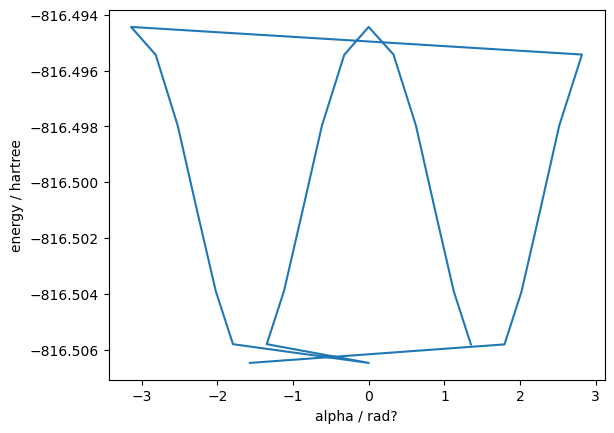

In [11]:
#plot alphas vs final_energies
import pylab 

pylab.plot(alphas, final_energies)
pylab.ylabel("energy / hartree")
pylab.xlabel("alpha / rad?")
pylab.savefig("out.png")

In [12]:
writer = Chem.SDWriter('mol90.sdf')
for cid in range(mol_90.GetNumConformers()):
    writer.write(mol_90, confId=cid)

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Geometry import Point3D
import numpy as np

# SMILES string
smi = '[H:16][c:9]1[c:5]([n:1][c:2]([n:6][c:10]1[H:17])[C:3]2=[C:7]([C:11](=[C:8]([S:4]2)[H:15])[H:13])[H:12])[H:14]'

# Create molecule from SMILES
mol = Chem.MolFromSmarts(smi)


# Generate initial 3D conformer to assign geometry
AllChem.EmbedMolecule(mol)

# Coordinates array (17,3) 
coords = mol_16_165.geometry # np array (17,3)

# Set atom positions using coords array
conf = mol.GetConformer()
for i in range(mol.GetNumAtoms()):
    x, y, z = coords[i]
    print(coords[i])
    conf.SetAtomPosition(i, Point3D(x, y, z))

# Write molecule to SDF file
with Chem.SDWriter('output_molecule.sdf') as writer:
    writer.write(mol)


for each mol in td_result.final_molecules.items():

file = 'biaryl_minimal/result_biaryl_016.json'
td_result = TorsionDriveResult.parse_file(file)
smiles = td_result.initial_molecule[0].extras["canonical_isomeric_explicit_hydrogen_mapped_smiles"]
name = smiles.replace("/", "")

# create a dataset in the same style as the SPICE HDF5
import h5py
from qcelemental.models.procedures import TorsionDriveResult
import numpy as np
import pathlib

# folder = pathlib.Path("TNet500_minimal")
# outputfile = h5py.File('TNet500-SPICE.hdf5', 'w')

folder = pathlib.Path("biaryl_minimal")
outputfile = h5py.File('test2-Biaryl-SPICE.hdf5', 'w')
        

def main():

    for file in folder.rglob("*.json"):
        print(file)
        td_result = TorsionDriveResult.parse_file(file)
        smiles = td_result.initial_molecule[0].extras["canonical_isomeric_explicit_hydrogen_mapped_smiles"]
        print(f'smi: {smiles}, {len(smiles)}')
        name = smiles.replace("/", "")
        group = outputfile.create_group(name)
        group.create_dataset("smiles", data=[smiles], dtype=h5py.string_dtype())
        group.create_dataset("atomic_numbers", data=td_result.initial_molecule[0].atomic_numbers, dtype=np.int16)
        energies, gradients, conformations = [], [], []
        for angle, molecule in td_result.final_molecules.items():
            energies.append(td_result.final_energies[angle])
            conformations.append(molecule.geometry)
            gradients.append(td_result.optimization_history[angle][0].trajectory[0].properties.return_gradient)
        conformations = group.create_dataset("conformations", data=np.array(conformations), dtype=np.float32)
        conformations.attrs["units"] = "bohr"
        ds = group.create_dataset("dft total energy", data=np.array(energies), dtype=np.float64)
        ds.attrs["units"] = "hartree"
        ds = group.create_dataset('dft total gradient', data=np.array(gradients), dtype=np.float32)
        ds.attrs["units"] = "hartree/bohr"


if __name__ == "__main__":
    main()

SyntaxError: invalid syntax (3959535123.py, line 35)